In [101]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import warnings

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

%matplotlib inline

C:\Users\bryan\Anaconda3\lib\subprocess.py:942: ResourceWarning: subprocess 18080 is still running
  _warn("subprocess %s is still running" % self.pid,
C:\Users\bryan\Anaconda3\lib\site-packages\ipykernel\zmqshell.py:408: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  connect_qtconsole(argv=arg_split(arg_s, os.name=='posix'))
C:\Users\bryan\Anaconda3\lib\site-packages\ipykernel\zmqshell.py:408: ResourceWarning: unclosed file <_io.BufferedReader name=8>
  connect_qtconsole(argv=arg_split(arg_s, os.name=='posix'))


In [102]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [226]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True)
df = df[df.date > '2016-06'].reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,48.910,49.376667,49.793333,50.126667,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,50.182,50.774000,51.252000,51.632000,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [227]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
df = df.loc[:,['date','Total US RigCount','wti_spot_lag_9','opec_surp_capac']]

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler

#df = df.drop(['world_cons','oecd_cons','non-oecd_cons','usa_net_import','usa_l48_prod'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot_lag_9,opec_surp_capac
0,2016-06-03,325.0,36.822,1.041334
1,2016-06-10,328.0,36.720,1.011001


In [105]:
df.shape

(226, 21)

## Train Test Split
Define features X, and target variable y

In [228]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

model_score = pd.DataFrame(columns=['model','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

#scaler = MinMaxScaler()
#scaler.fit(df.iloc[:,1:])
#X = scaler.transform(df.iloc[:,1:])
#X = pd.DataFrame(X,columns=df.iloc[:,1:].columns)
#X[['Total US RigCount','wti_spot_lag_14']].plot(figsize=(12,10))

In [229]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe,plot=True):

    mse_tt = []
    r2_tt = []
    mae_tt = []
    
    mse_tr = []
    r2_tr = []
    mae_tr = []
    
    if plot == True:
        fig, ax = plt.subplots(2, sharex=True, figsize=(18,10))
        ax[0].plot(date,y)
        ax[1].plot(date,y)
        ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
        ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        

        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            ax[0].plot(date[tr],y_tr_pred, label='train iter no'+str(ii+1))
            #ax[0].legend()
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
            ax[1].plot(date[tt],y_tt_pred, label='test iter no '+str(ii+1),)
            #ax[1].legend()
            
        plt.xticks(rotation=75)
        plt.show()

    else:
        
        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
    return np.mean(mse_tr), np.mean(r2_tr), np.mean(mae_tr), np.mean(mse_tt), np.mean(r2_tt), np.mean(mae_tt),

def add_model(model, errors):
    
    global model_score
    
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = errors
    
    row = {
        'model':model,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
    
    model_score = model_score.append(row,ignore_index=True)
    
    return errors

### Linear Regression 
Baseline model will be a linear regression with all features.

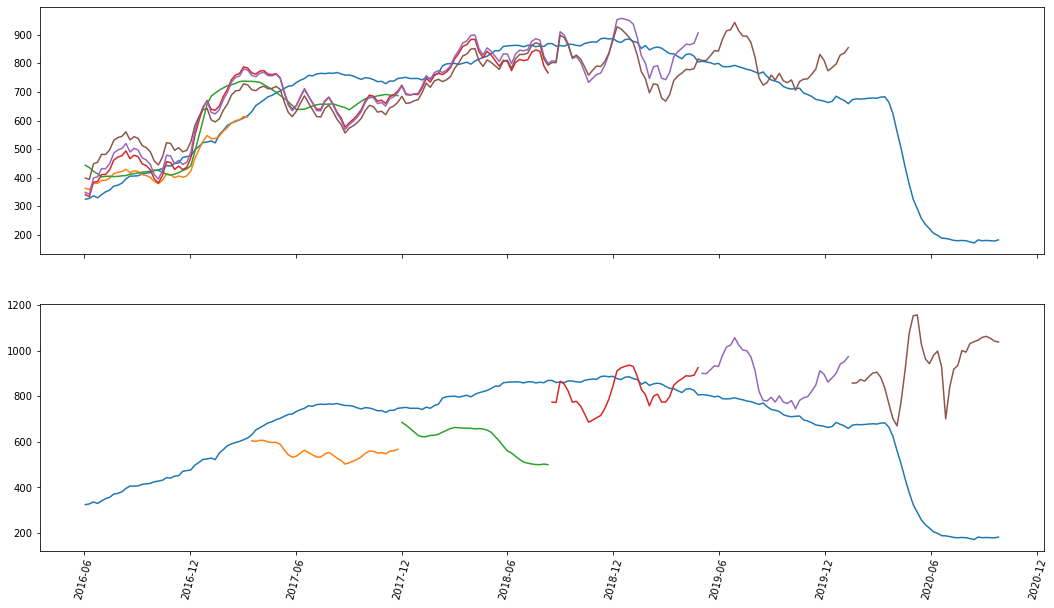

(74.11894812588734,
 0.6470160601866933,
 62.03524585575328,
 262.795445843565,
 -17.31269372325479,
 234.15038258610417)

In [230]:
# Baseline linear regression with no additional features
n_splits = 5

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

lin_base = plot_model(date,X,y,cv,pipe)
add_model('linear_base',lin_base)

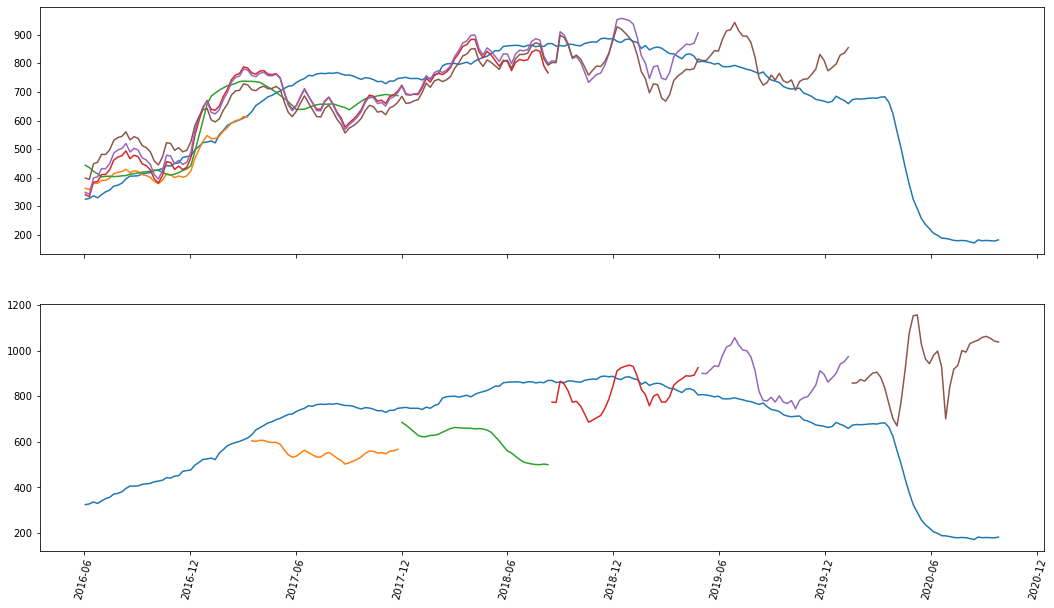

(74.11894812588734,
 0.647016060186693,
 62.03524585575328,
 262.7954458435649,
 -17.312693723254803,
 234.15038258610403)

In [231]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

lin_scal = plot_model(date,X,y,cv,pipe)
add_model('linear_scaled',lin_scal)

In [111]:
# Let's try with rolling window for the time series to account for the data being non-stationary

max_train_score = pd.DataFrame(columns=['n_splits','train_size','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')  

for n in np.arange(5,50,step=5):
    for i in np.arange(10,df.shape[0],step =10):
        cv = TimeSeriesSplit(n_splits=n,max_train_size=i)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        row = {
            'n_splits':n,
            'train_size':i,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        max_train_score = max_train_score.append(row,ignore_index=True)
    
warnings.filterwarnings('default')  

In [149]:
max_train_score.sort_values(by='rmse_tt', inplace=True)
max_train_score.to_csv(data_interim_dir + 'max_train_score.csv')

max_train_score.head() # n_splits = 45 / train_size = 40 ()

,n_splits,train_size,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
9318,45.0,40.0,4.975081,0.978263,3.919809,34.205834,-20.090224,29.885743
9332,45.0,54.0,7.693001,0.977343,6.140455,34.368336,-24.169508,29.757994
9322,45.0,44.0,5.738501,0.978005,4.542820,34.478121,-27.941887,30.331228
9331,45.0,53.0,7.528982,0.977722,6.006606,34.480139,-24.067836,29.874612
9333,45.0,55.0,7.918510,0.977608,6.290769,34.664574,-25.107966,30.210707


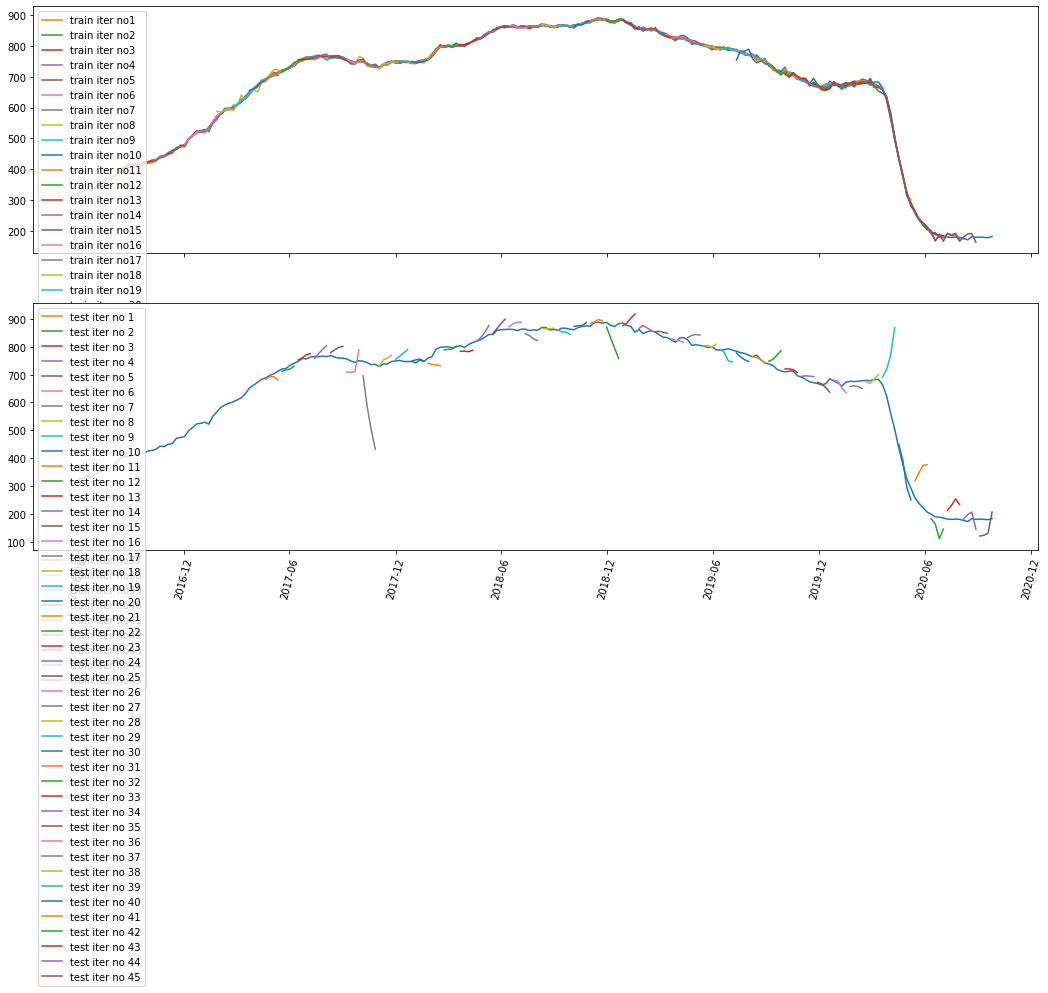

(4.975081051787915,
 0.9782626395551451,
 3.9198085018770192,
 34.20583370624464,
 -20.09022400334245,
 29.885742909600886)

In [113]:
# Use 112 as the others are too small
max_train_best = int(max_train_score.train_size[max_train_score.index[0]])
n_splits_best = int(max_train_score.n_splits[max_train_score.index[0]])

cv = TimeSeriesSplit(n_splits=n_splits_best,max_train_size=max_train_best)

plot_model(date,X,y,cv,pipe)

In [114]:
# Parameter tuning for SelectKBest - manual
k_score = pd.DataFrame(columns=['k','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')  

for i in np.arange(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    pipe = make_pipeline(scaler,feat_sel,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'k':i,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    k_score = k_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
k_score.sort_values(by='rmse_tr',inplace=True)
k_score.head()

,k,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
18,19.0,4.975081,0.978263,3.919809,34.205834,-20.090224,29.885743
17,18.0,5.185458,0.976551,4.087337,34.619250,-19.782212,30.431511
16,17.0,5.457997,0.974949,4.275523,33.764498,-11.631121,29.582645
15,16.0,5.768367,0.971627,4.536759,34.054468,-14.097221,29.788911
14,15.0,6.064226,0.966218,4.820786,33.815154,-19.461508,29.727468


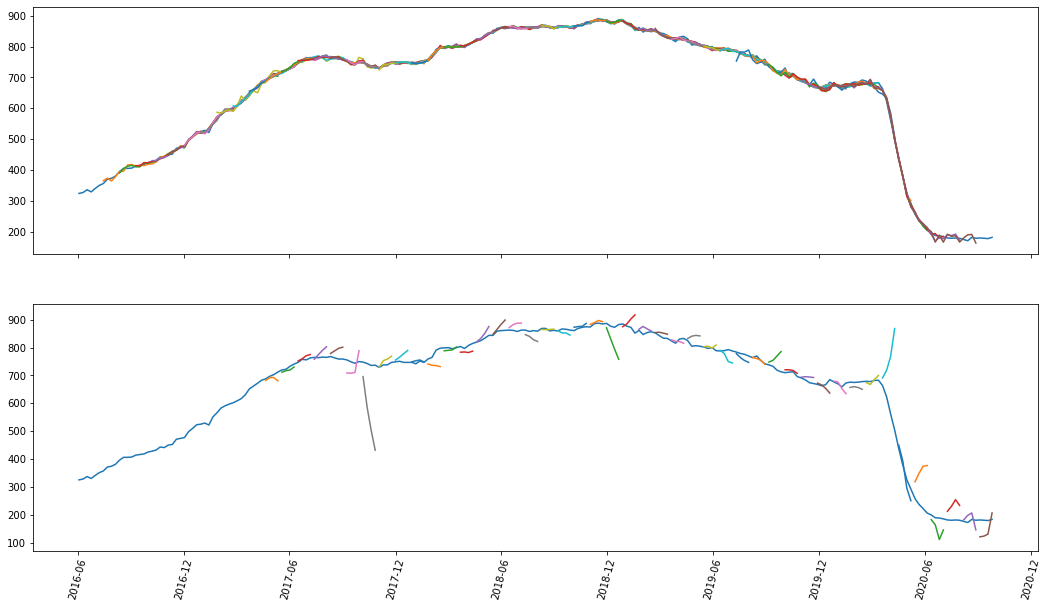

(4.975081051787915,
 0.9782626395551451,
 3.9198085018770192,
 34.20583370624464,
 -20.09022400334245,
 29.885742909600886)

In [116]:
k_best = int(k_score.k[k_score.index[0]])

feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lin_kbest = plot_model(date,X,y,cv,pipe)
add_model('linear_kbest',lin_kbest)

In [117]:
pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False)

world_cons               8.610685e+14
non-oecd_cons_smooth     3.701551e+12
world_cons_smooth        3.701551e+12
oecd_cons_smooth         2.880238e+12
non-opec_tot_prod        2.265708e+02
usa_l48_prod_smooth      1.897183e+02
opec_crud_capac          9.676773e+01
usa_net_import_smooth    2.040625e+01
wti_spot_lag_14          1.760402e+01
usa_net_import          -1.422363e+00
brent_spot              -1.002866e+01
wti_spot                -2.064891e+01
usa_l48_prod            -2.254395e+01
usa_stocks_all          -6.941455e+01
opec_surp_capac         -1.727518e+03
opec_tot_prod           -1.879151e+03
wti_spot_lag_9          -1.028334e+13
non-oecd_cons           -3.378356e+14
oecd_cons               -5.652969e+14
dtype: float64

In [ ]:
# Parameter tuning for linear regression - GridSearchCV
#feat_sel = SelectKBest(f_regression,k='all')
#pipe = make_pipeline(scaler,feat_sel,model)

#param_grid = {'selectkbest__k':np.arange(1,X.shape[1]+1)}

#gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)

#plot_model(date,X,y,cv,gs_cv)

In [ ]:
#selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
#coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
#features = pd.Series(coefs, index=X.columns[selected]).sort_values(ascending=False)

#print(gs_cv.best_params_)
#print(features)

### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

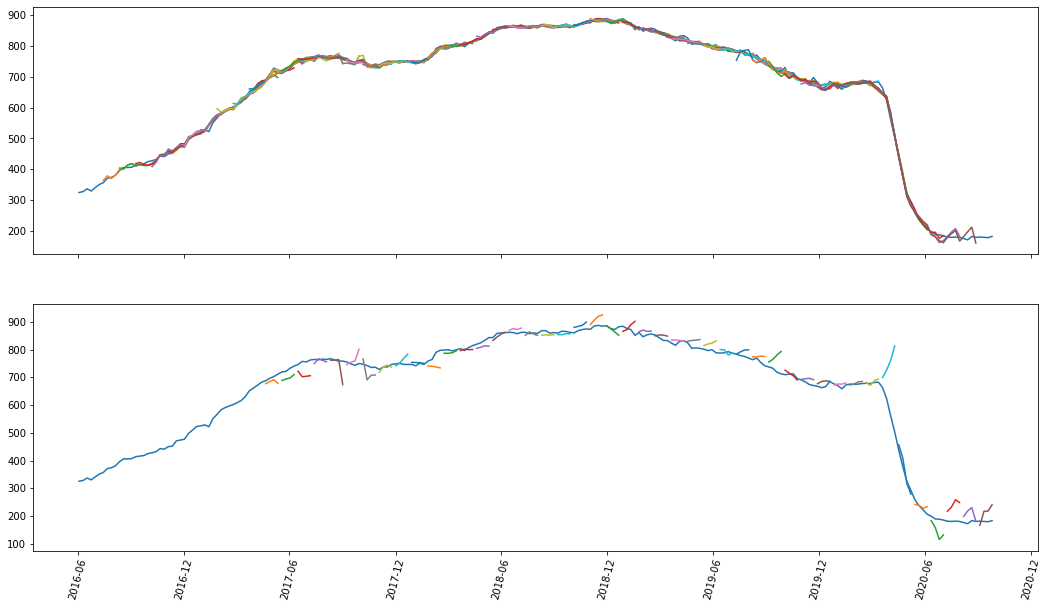

(6.519026820695918,
 0.9674823444028671,
 5.206796718824663,
 25.594712514564097,
 -34.21757152234656,
 22.263128464026526)

In [118]:
model = Ridge()
pipe = make_pipeline(scaler,model)

ridge_base = plot_model(date,X,y,cv,pipe)
add_model('ridge_base',ridge_base)

In [119]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.5,step=0.005):
    model = Ridge(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
99,0.496,6.141030,0.970677,4.874892,26.281506,-32.618357,22.841177
98,0.491,6.136379,0.970712,4.870921,26.297072,-32.880260,22.852002
97,0.486,6.131701,0.970748,4.866931,26.312911,-33.157308,22.862872
96,0.481,6.126996,0.970783,4.862904,26.329026,-33.449844,22.873788
95,0.476,6.122262,0.970818,4.858855,26.345423,-33.758037,22.884748


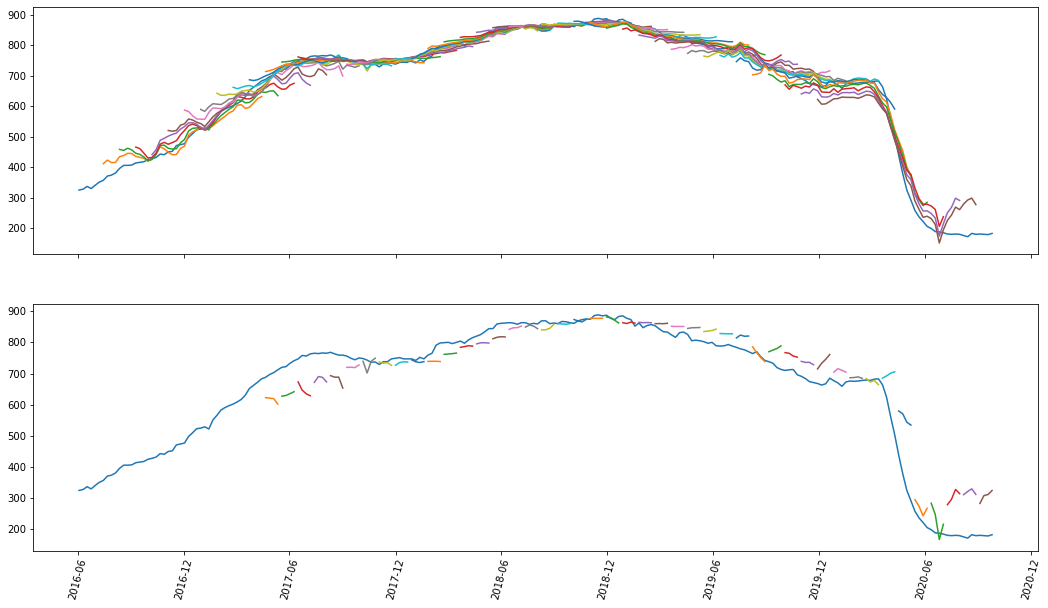

(20.361064808220277,
 0.4693225120477502,
 16.463247350850132,
 48.00277096390233,
 -1068.7430363907756,
 46.075483010801065)

In [120]:
alpha_best = alpha_score.index[0]
model = Ridge(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

ridge_alpha = plot_model(date,X,y,cv,pipe)
add_model('ridge_alpha',ridge_alpha)

In [121]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.1,0.5,step=0.001):
        model = Ridge(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)
        
warnings.filterwarnings('default')    

ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
7199,19.0,0.499,6.143808,0.970656,4.877261,26.272297,-32.468295,22.834704
7198,19.0,0.498,6.142883,0.970663,4.876472,26.275356,-32.517736,22.836860
7197,19.0,0.497,6.141957,0.970670,4.875683,26.278426,-32.567755,22.839017
7196,19.0,0.496,6.141030,0.970677,4.874892,26.281506,-32.618357,22.841177
7195,19.0,0.495,6.140102,0.970684,4.874099,26.284598,-32.669547,22.843338


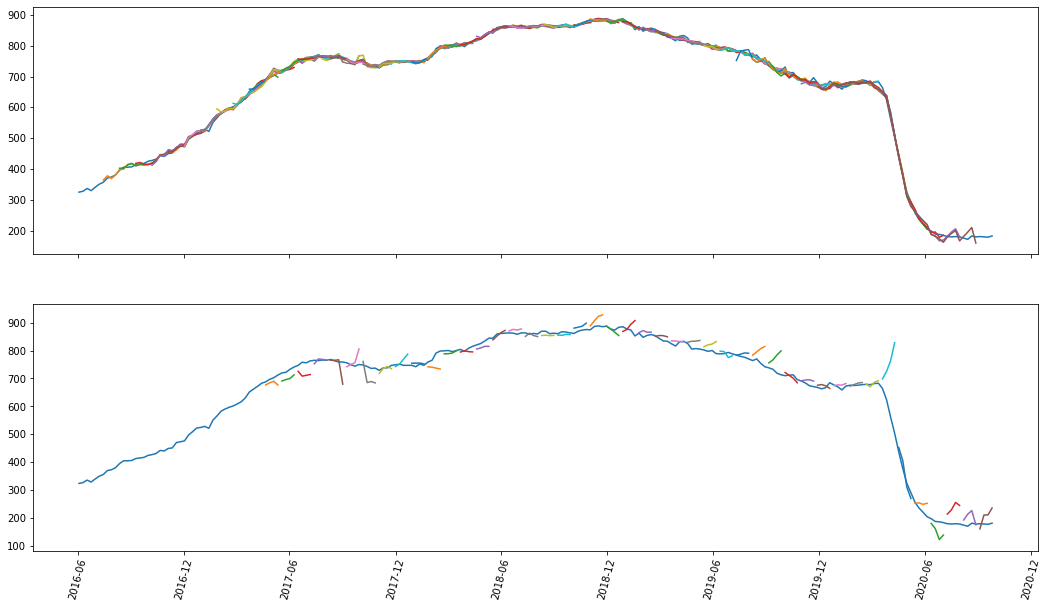

(6.143807874445219,
 0.9706560407117865,
 4.877260914657891,
 26.272296572235017,
 -32.46829539759253,
 22.834703866811832)

In [122]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Ridge(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

ridge_ak = plot_model(date,X,y,cv,pipe)
add_model('ridge_ak',ridge_ak)

In [123]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

usa_l48_prod_smooth      49.418370
usa_l48_prod             37.643155
non-opec_tot_prod        31.832658
wti_spot_lag_14          29.989707
opec_tot_prod            26.024290
oecd_cons                10.338433
brent_spot                7.924916
usa_net_import_smooth     7.131834
world_cons                4.536761
oecd_cons_smooth         -0.102523
non-oecd_cons_smooth     -0.102523
world_cons_smooth        -0.102523
wti_spot_lag_9           -0.102523
usa_net_import           -1.687040
opec_crud_capac          -4.273052
non-oecd_cons            -5.735989
wti_spot                 -8.295132
opec_surp_capac         -25.999430
usa_stocks_all          -33.582293
dtype: float64


### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2934.328163393504, tolerance: 152.1727975
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4287.322861025687, tolerance: 183.69939
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6644.853835635976, tolerance: 199.17527749999996
  model = cd_fast.enet_coordinate_descent(


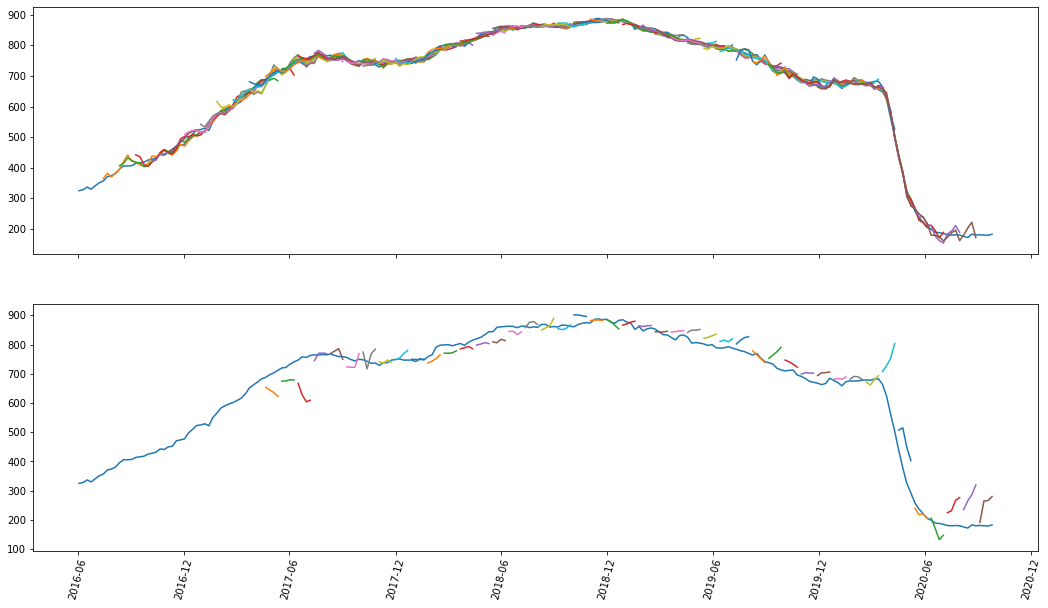

(9.49599257122135,
 0.9110662133557745,
 7.650663651677702,
 35.73020450449452,
 -46.55740359907994,
 33.109000115956476)

In [124]:
model = Lasso()
pipe = make_pipeline(scaler,model)

lasso_base = plot_model(date,X,y,cv,model)
add_model('lasso_base',lasso_base)

In [125]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for j in np.arange(0.75,2,step=0.005):
    model = Lasso(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
0,0.750,7.033044,0.944883,5.639556,22.817520,-97.459710,20.038240
1,0.755,7.039247,0.944653,5.644455,22.818375,-98.380365,20.039576
6,0.780,7.070135,0.943523,5.668804,22.819793,-102.297729,20.038033
7,0.785,7.076251,0.943303,5.673557,22.819983,-102.909339,20.035927
5,0.775,7.064044,0.943741,5.664040,22.820126,-101.627422,20.040107


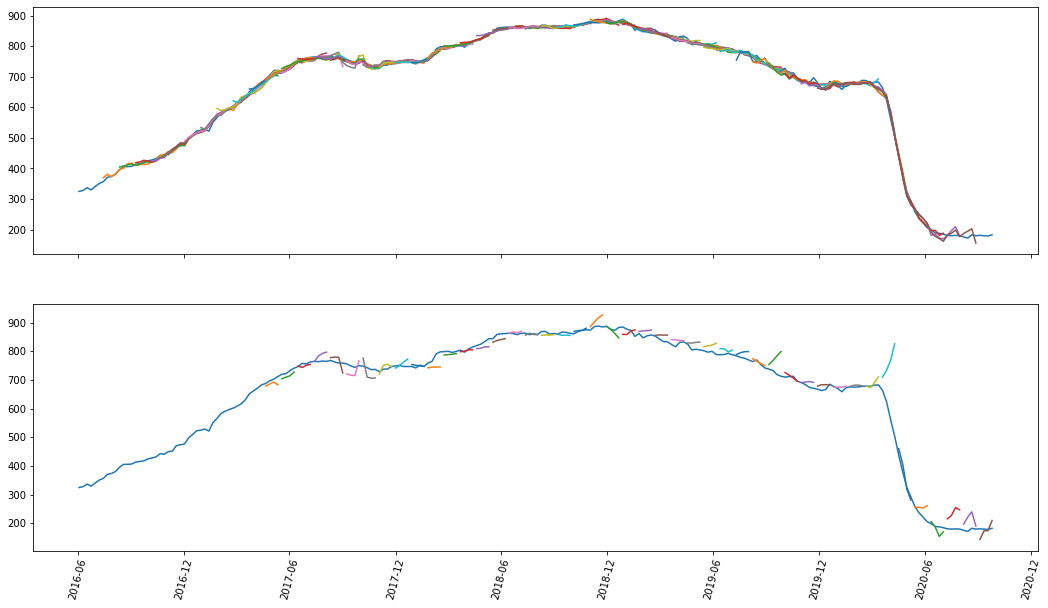

(7.0330439217793685,
 0.9448825414493053,
 5.639556499508737,
 22.81751985246604,
 -97.4597095796468,
 20.03823963552744)

In [126]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = Lasso(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

lasso_alpha = plot_model(date,X,y,cv,pipe)
add_model('lasso_alpha',lasso_alpha)

In [127]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.01,1,step=0.005):
        model = Lasso(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
3711,19.0,0.745,7.026887,0.945110,5.634655,22.816805,-96.505336,20.037211
3710,19.0,0.740,7.020721,0.945337,5.629727,22.816994,-95.511482,20.037583
3712,19.0,0.750,7.033044,0.944883,5.639556,22.817520,-97.459710,20.038240
3713,19.0,0.755,7.039247,0.944653,5.644455,22.818375,-98.380365,20.039576
3709,19.0,0.735,7.014589,0.945562,5.624810,22.819469,-94.504225,20.039879


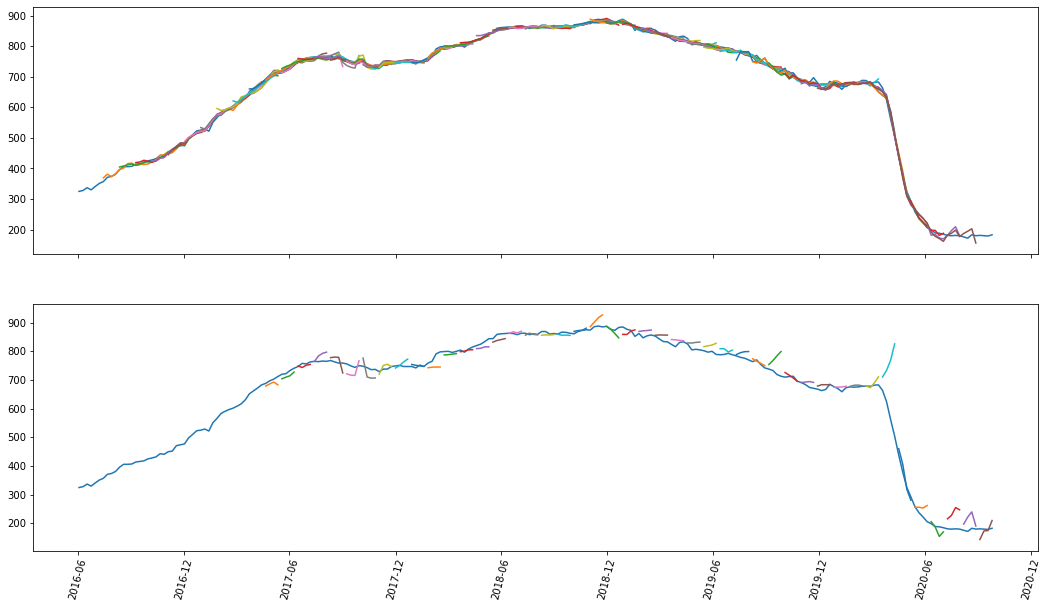

(7.026886891964233,
 0.9451103517448726,
 5.6346554002097005,
 22.81680527812553,
 -96.5053355224535,
 20.037211029190683)

In [128]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Lasso(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lasso_ak = plot_model(date,X,y,cv,pipe)
add_model('lasso_ak',lasso_ak)

In [140]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

### ElasticNet Regression 
Baseline model will be a default ElasticNet regression

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310.6193099382799, tolerance: 183.69939
  model = cd_fast.enet_coordinate_descent(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.04216601330336, tolerance: 199.17527749999996
  model = cd_fast.enet_coordinate_descent(


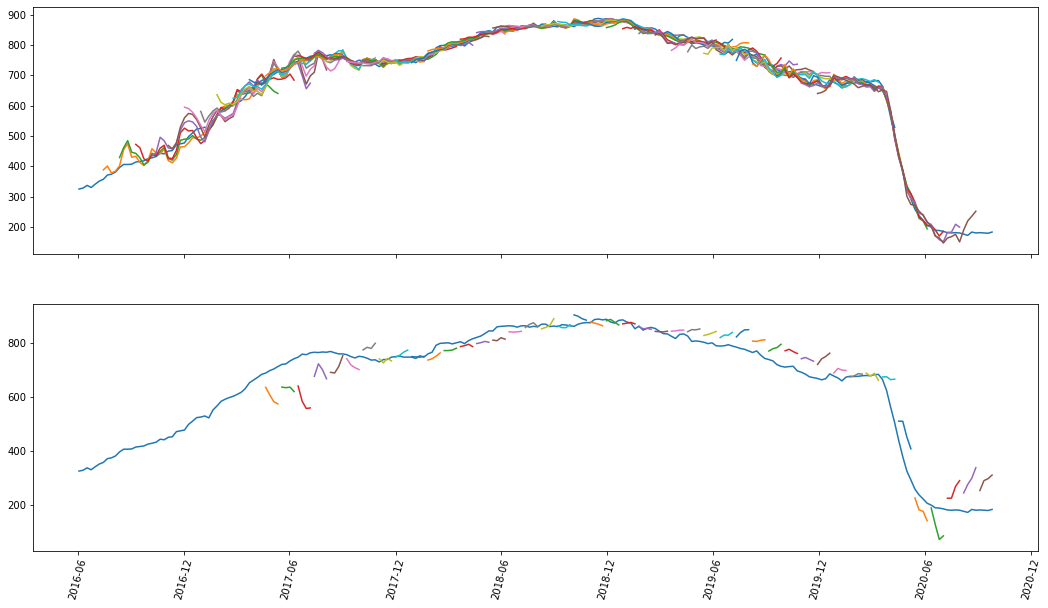

(15.349189222518081,
 0.837849583467289,
 12.378626540341411,
 46.887294532701404,
 -60.57616308992702,
 44.415743684072794)

In [129]:
model = ElasticNet()
pipe = make_pipeline(scaler,model)

elastic_base = plot_model(date,X,y,cv,model)
add_model('elastic_base',elastic_base)

In [130]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.1,step=0.0005):
    model = ElasticNet(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')   
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
108,0.0550,6.626520,0.966038,5.302358,25.500920,-27.529235,22.208298
109,0.0555,6.632866,0.965972,5.307993,25.501016,-27.404276,22.212605
107,0.0545,6.620141,0.966103,5.296693,25.501297,-27.692766,22.204263
110,0.0560,6.639181,0.965906,5.313605,25.501307,-27.310241,22.216769
106,0.0540,6.613728,0.966169,5.290985,25.501958,-27.907777,22.203009


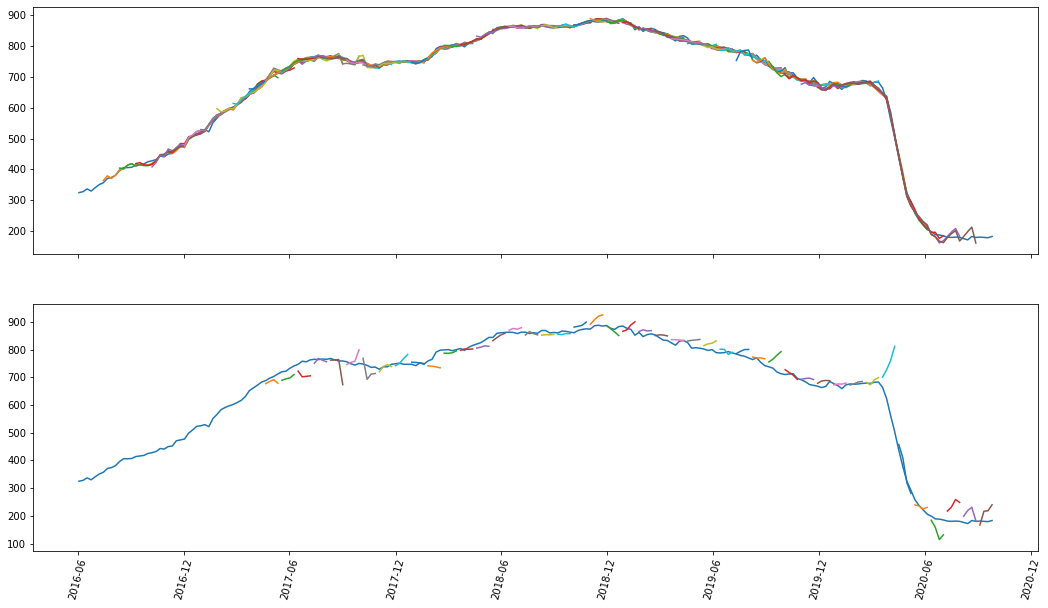

(6.62651977245745,
 0.9660377351177962,
 5.302358392029117,
 25.500920448477835,
 -27.52923503110823,
 22.208297566711128)

In [131]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = ElasticNet(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

elastic_alpha = plot_model(date,X,y,cv,pipe)
add_model('elastic_alpha',elastic_alpha)

In [132]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.001,0.2,step=0.001):
        model = ElasticNet(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

,k,alpha,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
3437,19.0,0.055,6.626520,0.966038,5.302358,25.500920,-27.529235,22.208298
3438,19.0,0.056,6.639181,0.965906,5.313605,25.501307,-27.310241,22.216769
3436,19.0,0.054,6.613728,0.966169,5.290985,25.501958,-27.907777,22.203009
3439,19.0,0.057,6.651693,0.965776,5.324697,25.502742,-27.188459,22.225407
3435,19.0,0.053,6.600805,0.966301,5.279457,25.503752,-28.557040,22.200151


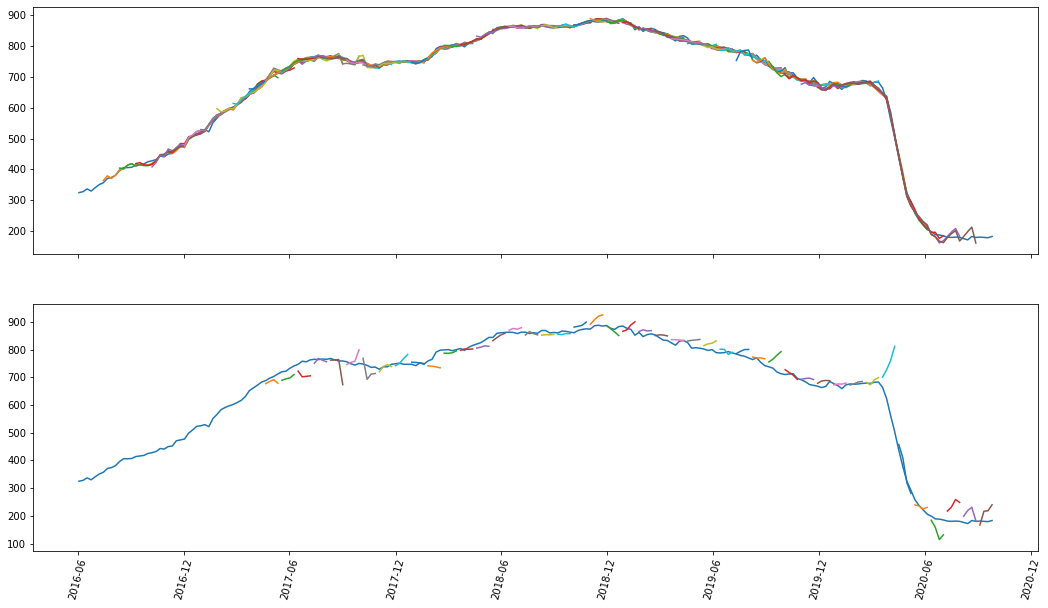

(6.62651977245745,
 0.9660377351177962,
 5.302358392029117,
 25.500920448477835,
 -27.52923503110823,
 22.208297566711128)

In [133]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = ElasticNet(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

elastic_ak = plot_model(date,X,y,cv,pipe)
add_model('elastic_ak',elastic_ak)

### Random Forest Regression 
Baseline model will be a default RF regression

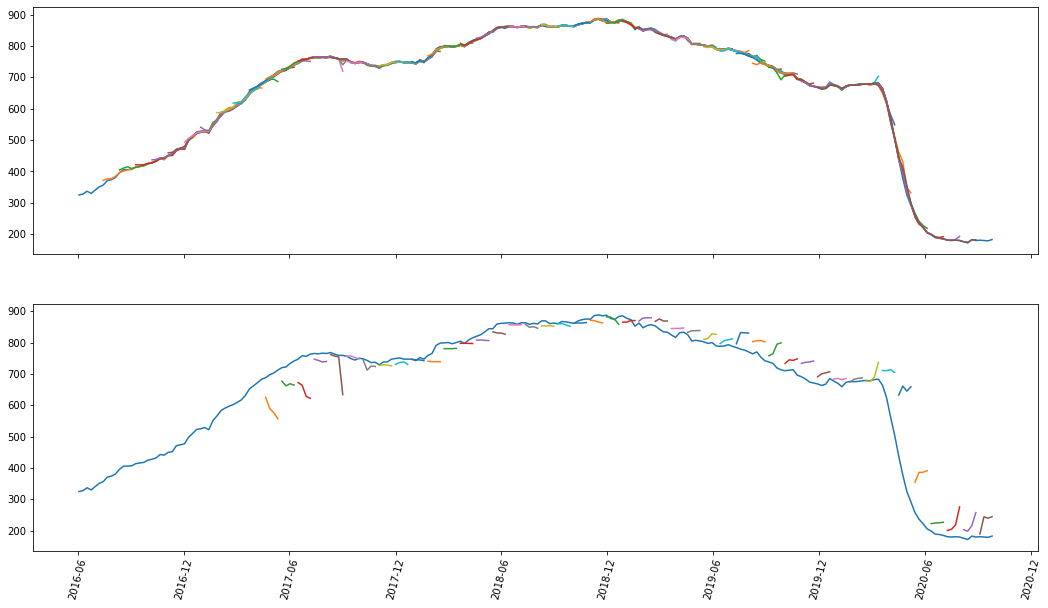

(3.8577066167084952,
 0.9885381419626428,
 2.5290333333333335,
 42.282804278131415,
 -376.72057293514706,
 39.01516666666666)

In [134]:
model = RandomForestRegressor(random_state=42)

pipe = make_pipeline(scaler,model)

rand_base = plot_model(date,X,y,cv,model)
add_model('rand_base',rand_base)

In [135]:
est_score = pd.DataFrame(columns=['n_estimators','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for n in np.arange(1,100,step=1):
    model = RandomForestRegressor(n_estimators = n)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'n_estimators':n,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    est_score = est_score.append(new_row,ignore_index=True)
        
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

,n_estimators,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
6,7.0,5.711914,0.980542,3.490238,39.000338,-315.457922,35.807937
3,4.0,9.041013,0.957403,4.516528,39.828523,-657.046873,37.000000
7,8.0,5.982486,0.977533,3.561181,40.322832,-412.465794,36.805556
77,78.0,4.189196,0.987905,2.713283,40.888839,-1248.577709,37.982764
10,11.0,5.062563,0.979214,3.172323,40.914898,-577.963512,38.402020


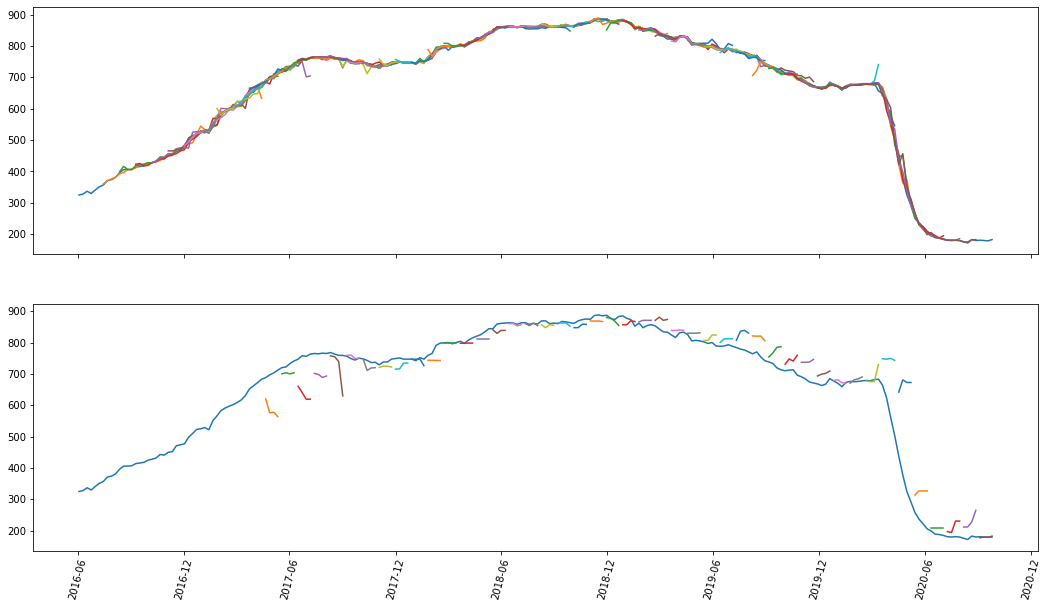

(6.005059977167359,
 0.9798555301084874,
 3.5492857142857157,
 40.79656772635035,
 -653.5341742984529,
 37.92539682539682)

In [136]:
est_best = int(est_score.n_estimators[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,model)

rand_est = plot_model(date,X,y,cv,pipe)
add_model('rand_est',rand_est)

In [137]:
est_score = pd.DataFrame(columns=['k','n_estimate','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for n in np.arange(1,100,step=1):
        model = RandomForestRegressor(n_estimators = n)
        pipe = make_pipeline(scaler,feat_sel,model)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'n_estimate':n,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        est_score = est_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

,k,n_estimate,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
198,3.0,1.0,8.646242,0.930315,3.706111,32.319685,-1532.852564,28.855556
113,2.0,15.0,4.439401,0.979455,3.083036,33.012422,-130.970604,29.943370
130,2.0,32.0,4.193550,0.981421,3.006432,33.091401,-281.300594,29.981589
129,2.0,31.0,4.262644,0.980956,3.043085,33.160001,-174.300543,29.958935
164,2.0,66.0,4.057086,0.981092,2.929497,33.313613,-263.004269,30.091894


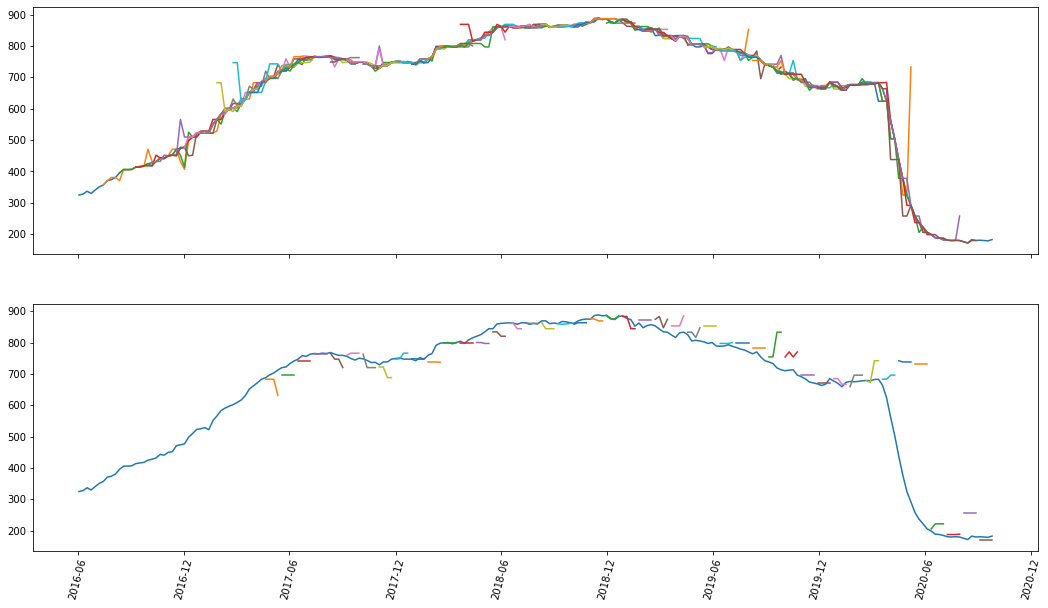

(11.44522047488218,
 0.8935390635775785,
 4.4494444444444445,
 44.53992992055268,
 -1356.6532367690725,
 41.75555555555555)

In [138]:
est_best = int(est_score.n_estimate[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,feat_sel,model)

rand_nk = plot_model(date,X,y,cv,pipe)
add_model('rand_nk',rand_nk)

In [139]:
model_score.sort_values(by='rmse_tt')

,model,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt
8,lasso_ak,7.026887,0.945110,5.634655,22.816805,-96.505336,20.037211
7,lasso_alpha,7.033044,0.944883,5.639556,22.817520,-97.459710,20.038240
10,elastic_alpha,6.626520,0.966038,5.302358,25.500920,-27.529235,22.208298
11,elastic_ak,6.626520,0.966038,5.302358,25.500920,-27.529235,22.208298
3,ridge_base,6.519027,0.967482,5.206797,25.594713,-34.217572,22.263128
5,ridge_ak,6.143808,0.970656,4.877261,26.272297,-32.468295,22.834704
2,linear_kbest,4.975081,0.978263,3.919809,34.205834,-20.090224,29.885743
6,lasso_base,9.495993,0.911066,7.650664,35.730205,-46.557404,33.109000
13,rand_est,6.005060,0.979856,3.549286,40.796568,-653.534174,37.925397
12,rand_base,3.857707,0.988538,2.529033,42.282804,-376.720573,39.015167


### XGBoost Regression 
Baseline model will be using default parameters

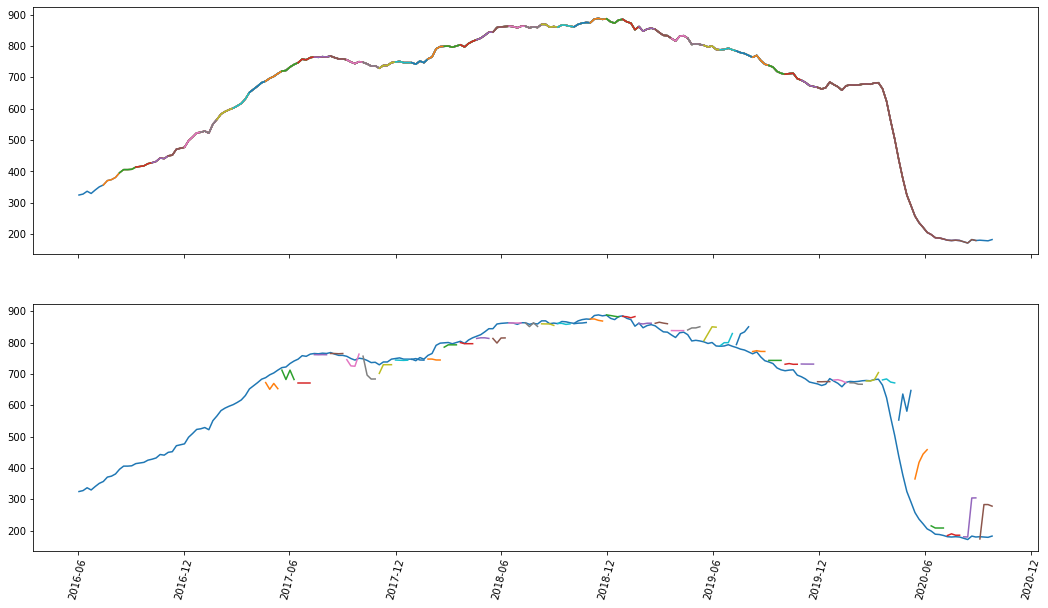

(0.0006460206485086155,
 0.9999999994814649,
 0.0004894171820746528,
 34.90119211392263,
 -65055.36171196873,
 31.509459092881944)

In [179]:
import xgboost as xgb

model = xgb.XGBRegressor()
pipe = make_pipeline(scaler, model)

xgb_base = plot_model(date,X,y,cv,pipe)
add_model('xgb_base',xgb_base)

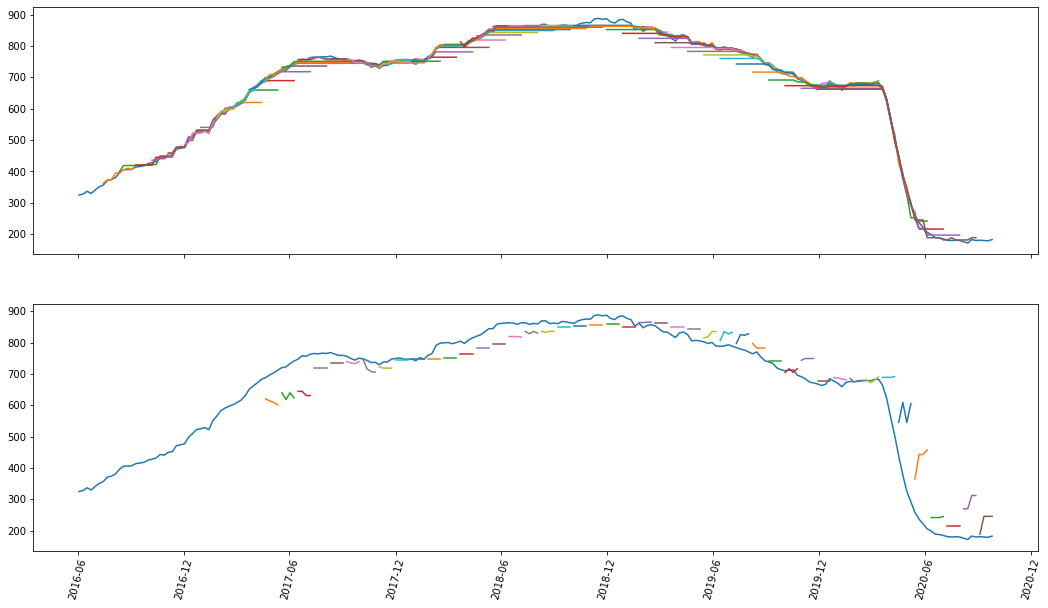

(11.6411856512756,
 -0.8983923364957735,
 8.188628260294594,
 46.28570049583334,
 -383.74764794233107,
 44.313575490315756)

In [189]:
est_score = pd.DataFrame(columns=['learn_rate','gamma','lambda','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

# eta [0,1], gamma [0, inf] , lambda [0, inf], nrounds [def = 100]
eta = np.arange(0,1,step = 0.2)

# gamma [0, inf]
gamma = [0,0.1,1,10,100]

# lambda [0, inf]
reg_lambda = [0,0.1,1,10,100]

# alpha [def = 1]
reg_alpha = [0,0.1,1,10,100]

# nrounds [def = 100]
nrounds = [10,100,1000]

for e in eta:
    for g in gamma:
        for l in reg_lambda:
            for a in reg_alpha:
                model = xgb.XGBRegressor(eta=e, gamma=g,reg_lambda=l,reg_alpha=a)
                pipe = make_pipeline(scaler,model)

                rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

                new_row = {
                    'learn_rate':e,
                    'gamma':g,
                    'lambda':l,
                    'alpha':a,
                    #'nrounds':n,
                    'rmse_tr':rmse_tr,
                    'r2_tr':r2_tr,
                    'mae_tr':mae_tr, 
                    'rmse_tt':rmse_tt,
                    'r2_tt':r2_tt,
                    'mae_tt':mae_tt, 
                }

                xgb_score = xgb_score.append(new_row,ignore_index=True)

In [217]:
xgb_score.sort_values(by='rmse_tt',inplace=True)
xgb_score.head()

,rmse_tr,r2_tr,mae_tr,rmse_tt,r2_tt,mae_tt,alpha,gamma,lambda,learn_rate,nrounds
2469,0.927091,0.999108,0.555544,32.434283,-831.523673,29.856388,0.0,1.0,10.0,0.2,1000.0
2468,0.927091,0.999108,0.555544,32.434283,-831.523673,29.856388,0.0,1.0,10.0,0.2,100.0
2467,0.927091,0.999108,0.555544,32.434283,-831.523673,29.856388,0.0,1.0,10.0,0.2,10.0
2400,0.743866,0.999437,0.331862,32.470659,-311.328542,29.903930,1.0,0.1,10.0,0.2,1000.0
2398,0.743866,0.999437,0.331862,32.470659,-311.328542,29.903930,1.0,0.1,10.0,0.2,10.0


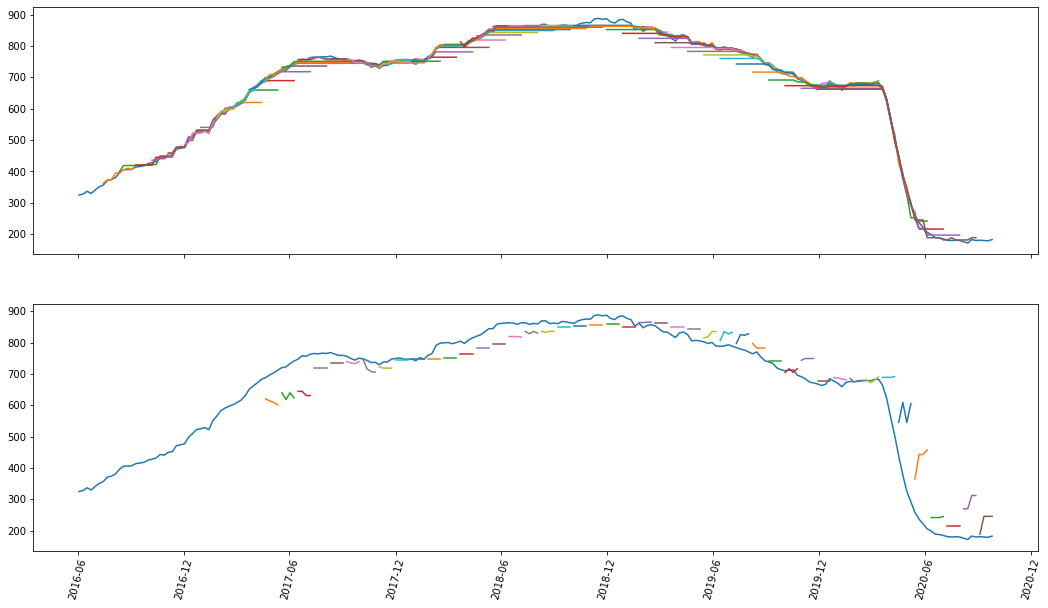

(11.6411856512756,
 -0.8983923364957735,
 8.188628260294594,
 46.28570049583334,
 -383.74764794233107,
 44.313575490315756)

In [224]:
i = 3

alpha_best = int(xgb_score.alpha[xgb_score.index[i]])
gamma_best = int(xgb_score.gamma[xgb_score.index[i]])
lambda_best = int(xgb_score['lambda'][xgb_score.index[i]])
learn_rate_best = int(xgb_score.learn_rate[xgb_score.index[i]])

model = xgb.XGBRegressor(eta=learn_rate_best, gamma=gamma_best,reg_lambda=lambda_best,reg_alpha=alpha_best)

xgb_opt = plot_model(date,X,y,cv,pipe)
add_model('xgb_opt',xgb_opt)